In [1]:
import warnings
warnings.filterwarnings("ignore")

import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline  
# it will show where it stored in a path but it is not necessary to write.

import seaborn as sns

from math import radians, cos, sin, sqrt, asin

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
plt.rcParams["figure.figsize"]=[15,8]

In [3]:
pd.options.display.max_columns = None

pd.options.display.max_rows = None

pd.options.display.float_format ="{:.6f}".format

In [4]:
df_taxi=pd.read_csv("TaxiFare.csv")
df_taxi.head()

,unique_id,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger
0,26:21.0,4.500000,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.900000,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.700000,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.700000,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.300000,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
df_taxi = df_taxi.drop("unique_id", axis=1)

In [6]:
df_taxi.shape

(50000, 7)

In [7]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   amount                50000 non-null  float64
 1   date_time_of_pickup   50000 non-null  object 
 2   longitude_of_pickup   50000 non-null  float64
 3   latitude_of_pickup    50000 non-null  float64
 4   longitude_of_dropoff  50000 non-null  float64
 5   latitude_of_dropoff   50000 non-null  float64
 6   no_of_passenger       50000 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 2.7+ MB


In [8]:
df_taxi.dtypes

amount                  float64
date_time_of_pickup      object
longitude_of_pickup     float64
latitude_of_pickup      float64
longitude_of_dropoff    float64
latitude_of_dropoff     float64
no_of_passenger           int64
dtype: object

In [9]:
df_taxi.isnull().sum()

amount                  0
date_time_of_pickup     0
longitude_of_pickup     0
latitude_of_pickup      0
longitude_of_dropoff    0
latitude_of_dropoff     0
no_of_passenger         0
dtype: int64

In [10]:
df_taxi.date_time_of_pickup = pd.to_datetime(df_taxi.date_time_of_pickup, errors="coerce")

In [11]:
df_taxi.dtypes

amount                              float64
date_time_of_pickup     datetime64[ns, UTC]
longitude_of_pickup                 float64
latitude_of_pickup                  float64
longitude_of_dropoff                float64
latitude_of_dropoff                 float64
no_of_passenger                       int64
dtype: object

In [12]:
df_taxi=df_taxi.assign(hour=df_taxi.date_time_of_pickup.dt.hour,
                      day=df_taxi.date_time_of_pickup.dt.day,
                      month=df_taxi.date_time_of_pickup.dt.month,
                      year=df_taxi.date_time_of_pickup.dt.year,
                      dayofweek=df_taxi.date_time_of_pickup.dt.dayofweek)

df_taxi.head()

,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,dayofweek
0,4.500000,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,2009,0
1,16.900000,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010,1
2,5.700000,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,2011,3
3,7.700000,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,2012,5
4,5.300000,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,2010,1


In [13]:
# function to calculate the travel distance from the longitudes and latitudes
#The Haversine formula calculates the shortest distance between two points on a sphere using their
#latitudes and longitudes measured along the surface. It is important for use in navigation.
#where r is the radius of the earth(6371 km)
def distance_transform(longitude1, latitude1, longitude2, latitude2):
    travel_dist = []
    
    for pos in range(len(longitude1)):
        long1,lati1,long2,lati2 = map(radians,[longitude1[pos],latitude1[pos],longitude2[pos],
                                               latitude2[pos]])
        dist_long = long2 - long1
        dist_lati = lati2 - lati1
        a = sin(dist_lati/2)**2 + cos(lati1) * cos(lati2) * sin(dist_long/2)**2
        c = 2 * asin(sqrt(a))*6371
        travel_dist.append(c)
       
    return travel_dist

In [14]:
#Add a new variable travel distance
#to_numpy(): Convert the DataFrame to a NumPy array

df_taxi['travel_dist_km'] = distance_transform(df_taxi['longitude_of_pickup'].to_numpy(),
                                                df_taxi['latitude_of_pickup'].to_numpy(),
                                                df_taxi['longitude_of_dropoff'].to_numpy(),
                                                df_taxi['latitude_of_dropoff'].to_numpy()
                                              )

In [15]:
df_taxi.head()

,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,dayofweek,travel_dist_km
0,4.500000,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,2009,0,1.030764
1,16.900000,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010,1,8.450134
2,5.700000,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,2011,3,1.389525
3,7.700000,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,2012,5,2.799270
4,5.300000,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,2010,1,1.999157


In [16]:
df_taxi=df_taxi.drop("date_time_of_pickup", axis=1)

In [17]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   amount                50000 non-null  float64
 1   longitude_of_pickup   50000 non-null  float64
 2   latitude_of_pickup    50000 non-null  float64
 3   longitude_of_dropoff  50000 non-null  float64
 4   latitude_of_dropoff   50000 non-null  float64
 5   no_of_passenger       50000 non-null  int64  
 6   hour                  50000 non-null  int32  
 7   day                   50000 non-null  int32  
 8   month                 50000 non-null  int32  
 9   year                  50000 non-null  int32  
 10  dayofweek             50000 non-null  int32  
 11  travel_dist_km        50000 non-null  float64
dtypes: float64(6), int32(5), int64(1)
memory usage: 3.6 MB


In [18]:
df_taxi.describe().T

,count,mean,std,min,25%,50%,75%,max
amount,50000.000000,11.364171,9.685557,-5.000000,6.000000,8.500000,12.500000,200.000000
longitude_of_pickup,50000.000000,-72.509756,10.393860,-75.423848,-73.992062,-73.981840,-73.967148,40.783472
latitude_of_pickup,50000.000000,39.933759,6.224857,-74.006893,40.734880,40.752678,40.767360,401.083332
longitude_of_dropoff,50000.000000,-72.504616,10.407570,-84.654241,-73.991152,-73.980082,-73.963584,40.851027
latitude_of_dropoff,50000.000000,39.926251,6.014737,-74.006377,40.734372,40.753372,40.768167,43.415190
no_of_passenger,50000.000000,1.667840,1.289195,0.000000,1.000000,1.000000,2.000000,6.000000
hour,50000.000000,13.489080,6.506935,0.000000,9.000000,14.000000,19.000000,23.000000
day,50000.000000,15.672040,8.660789,1.000000,8.000000,16.000000,23.000000,31.000000
month,50000.000000,6.273300,3.461157,1.000000,3.000000,6.000000,9.000000,12.000000
year,50000.000000,2011.739260,1.862639,2009.000000,2010.000000,2012.000000,2013.000000,2015.000000


In [19]:
df_taxi = df_taxi.loc[(df_taxi.amount >= 2.5)]

In [20]:
print("Remaining Observations in the dataset:", df_taxi.shape)

Remaining Observations in the dataset: (49990, 12)


In [21]:
df_taxi = df_taxi.loc[(df_taxi.travel_dist_km >= 1) | (df_taxi.travel_dist_km <= 130)]
print("Remaining Observations in the dataset:", df_taxi.shape)

Remaining Observations in the dataset: (49990, 12)


In [22]:
incorrect_coordinates = df_taxi.loc[(df_taxi.latitude_of_pickup > 90) | (df_taxi.latitude_of_pickup <= -90) |
                                   (df_taxi.latitude_of_dropoff > 90) | (df_taxi.latitude_of_dropoff <= -90) |
                                   (df_taxi.longitude_of_pickup > 180) | (df_taxi.longitude_of_pickup <= -180) |
                                   (df_taxi.longitude_of_dropoff > 180) | (df_taxi.longitude_of_dropoff <= -180)].index

In [23]:
df_taxi.drop(incorrect_coordinates, inplace=True, errors="ignore")

In [24]:
print("Remaining Observations in the dataset:", df_taxi.shape)

Remaining Observations in the dataset: (49989, 12)


In [25]:
Total= df_taxi.isnull().sum().sort_values(ascending= False)
Percent = (df_taxi.isnull().sum()*100/df_taxi.isnull().count()).sort_values(ascending= False)
missing_data= pd.concat([Total,Percent], axis=1, keys=['Total', 'percentage of missing values'])
missing_data['Type']= df_taxi[missing_data.index].dtypes
missing_data

,Total,percentage of missing values,Type
amount,0,0.000000,float64
longitude_of_pickup,0,0.000000,float64
latitude_of_pickup,0,0.000000,float64
longitude_of_dropoff,0,0.000000,float64
latitude_of_dropoff,0,0.000000,float64
no_of_passenger,0,0.000000,int64
hour,0,0.000000,int32
day,0,0.000000,int32
month,0,0.000000,int32
year,0,0.000000,int32


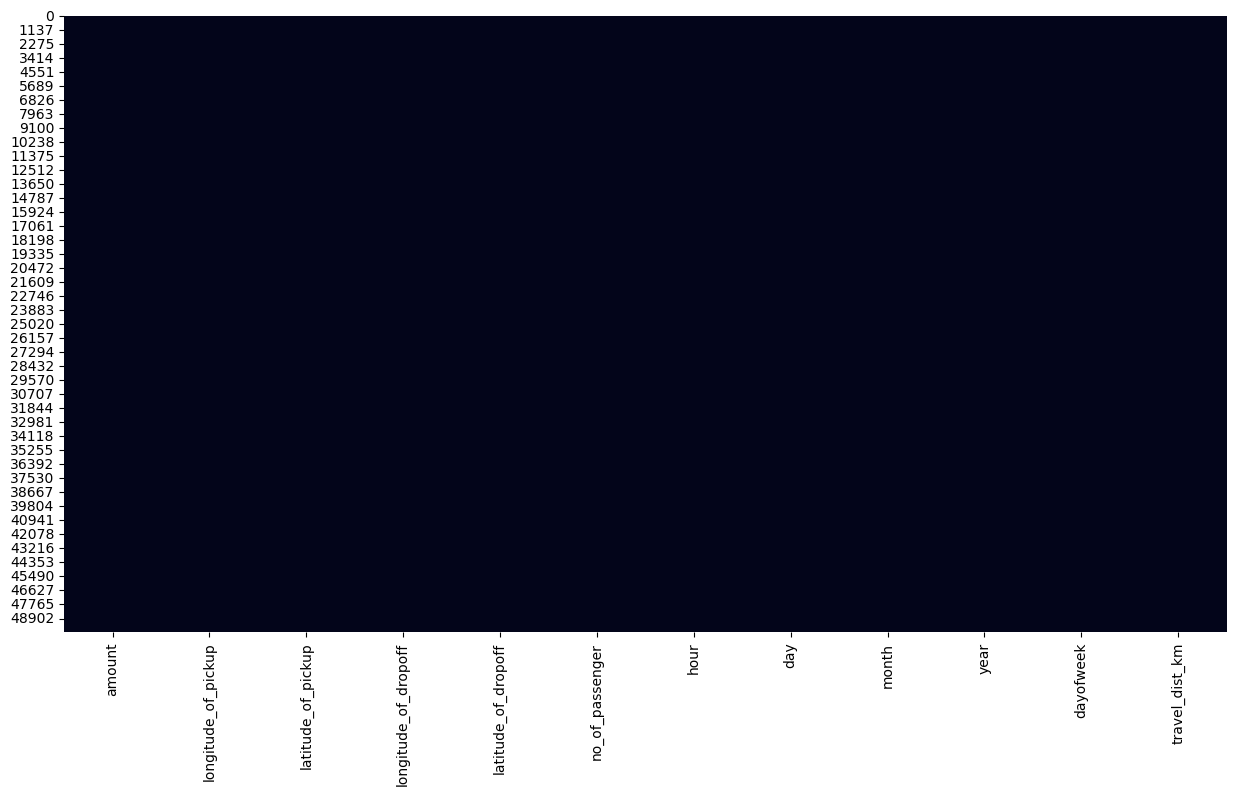

In [26]:
sns.heatmap(df_taxi.isnull(),cbar=False)
plt.show()

In [27]:
corr=df_taxi.corr(numeric_only=True)
corr

,amount,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,dayofweek,travel_dist_km
amount,1.000000,0.005905,-0.006563,0.004452,-0.005600,0.016506,-0.022009,-0.001417,0.026742,0.121081,0.000542,0.016451
longitude_of_pickup,0.005905,1.000000,-0.984132,0.956613,-0.947401,-0.005614,0.004913,0.006008,0.000402,-0.001264,-0.003224,0.143712
latitude_of_pickup,-0.006563,-0.984132,1.000000,-0.943741,0.961374,0.003982,-0.004313,-0.008884,0.000498,-0.000925,0.001911,-0.130943
longitude_of_dropoff,0.004452,0.956613,-0.943741,1.000000,-0.982102,-0.004874,0.005506,0.005221,0.001322,-0.000327,-0.002441,0.143172
latitude_of_dropoff,-0.005600,-0.947401,0.961374,-0.982102,1.000000,0.002898,-0.004530,-0.008012,-0.000341,-0.001817,0.001626,-0.124844
no_of_passenger,0.016506,-0.005614,0.003982,-0.004874,0.002898,1.000000,0.011400,0.006787,0.009099,0.006385,0.038581,-0.005371
hour,-0.022009,0.004913,-0.004313,0.005506,-0.004530,0.011400,1.000000,-0.008192,-0.001916,0.004167,-0.091267,0.000644
day,-0.001417,0.006008,-0.008884,0.005221,-0.008012,0.006787,-0.008192,1.000000,-0.017266,-0.011155,0.008422,0.010610
month,0.026742,0.000402,0.000498,0.001322,-0.000341,0.009099,-0.001916,-0.017266,1.000000,-0.115726,-0.010004,-0.009217
year,0.121081,-0.001264,-0.000925,-0.000327,-0.001817,0.006385,0.004167,-0.011155,-0.115726,1.000000,0.006808,0.022136


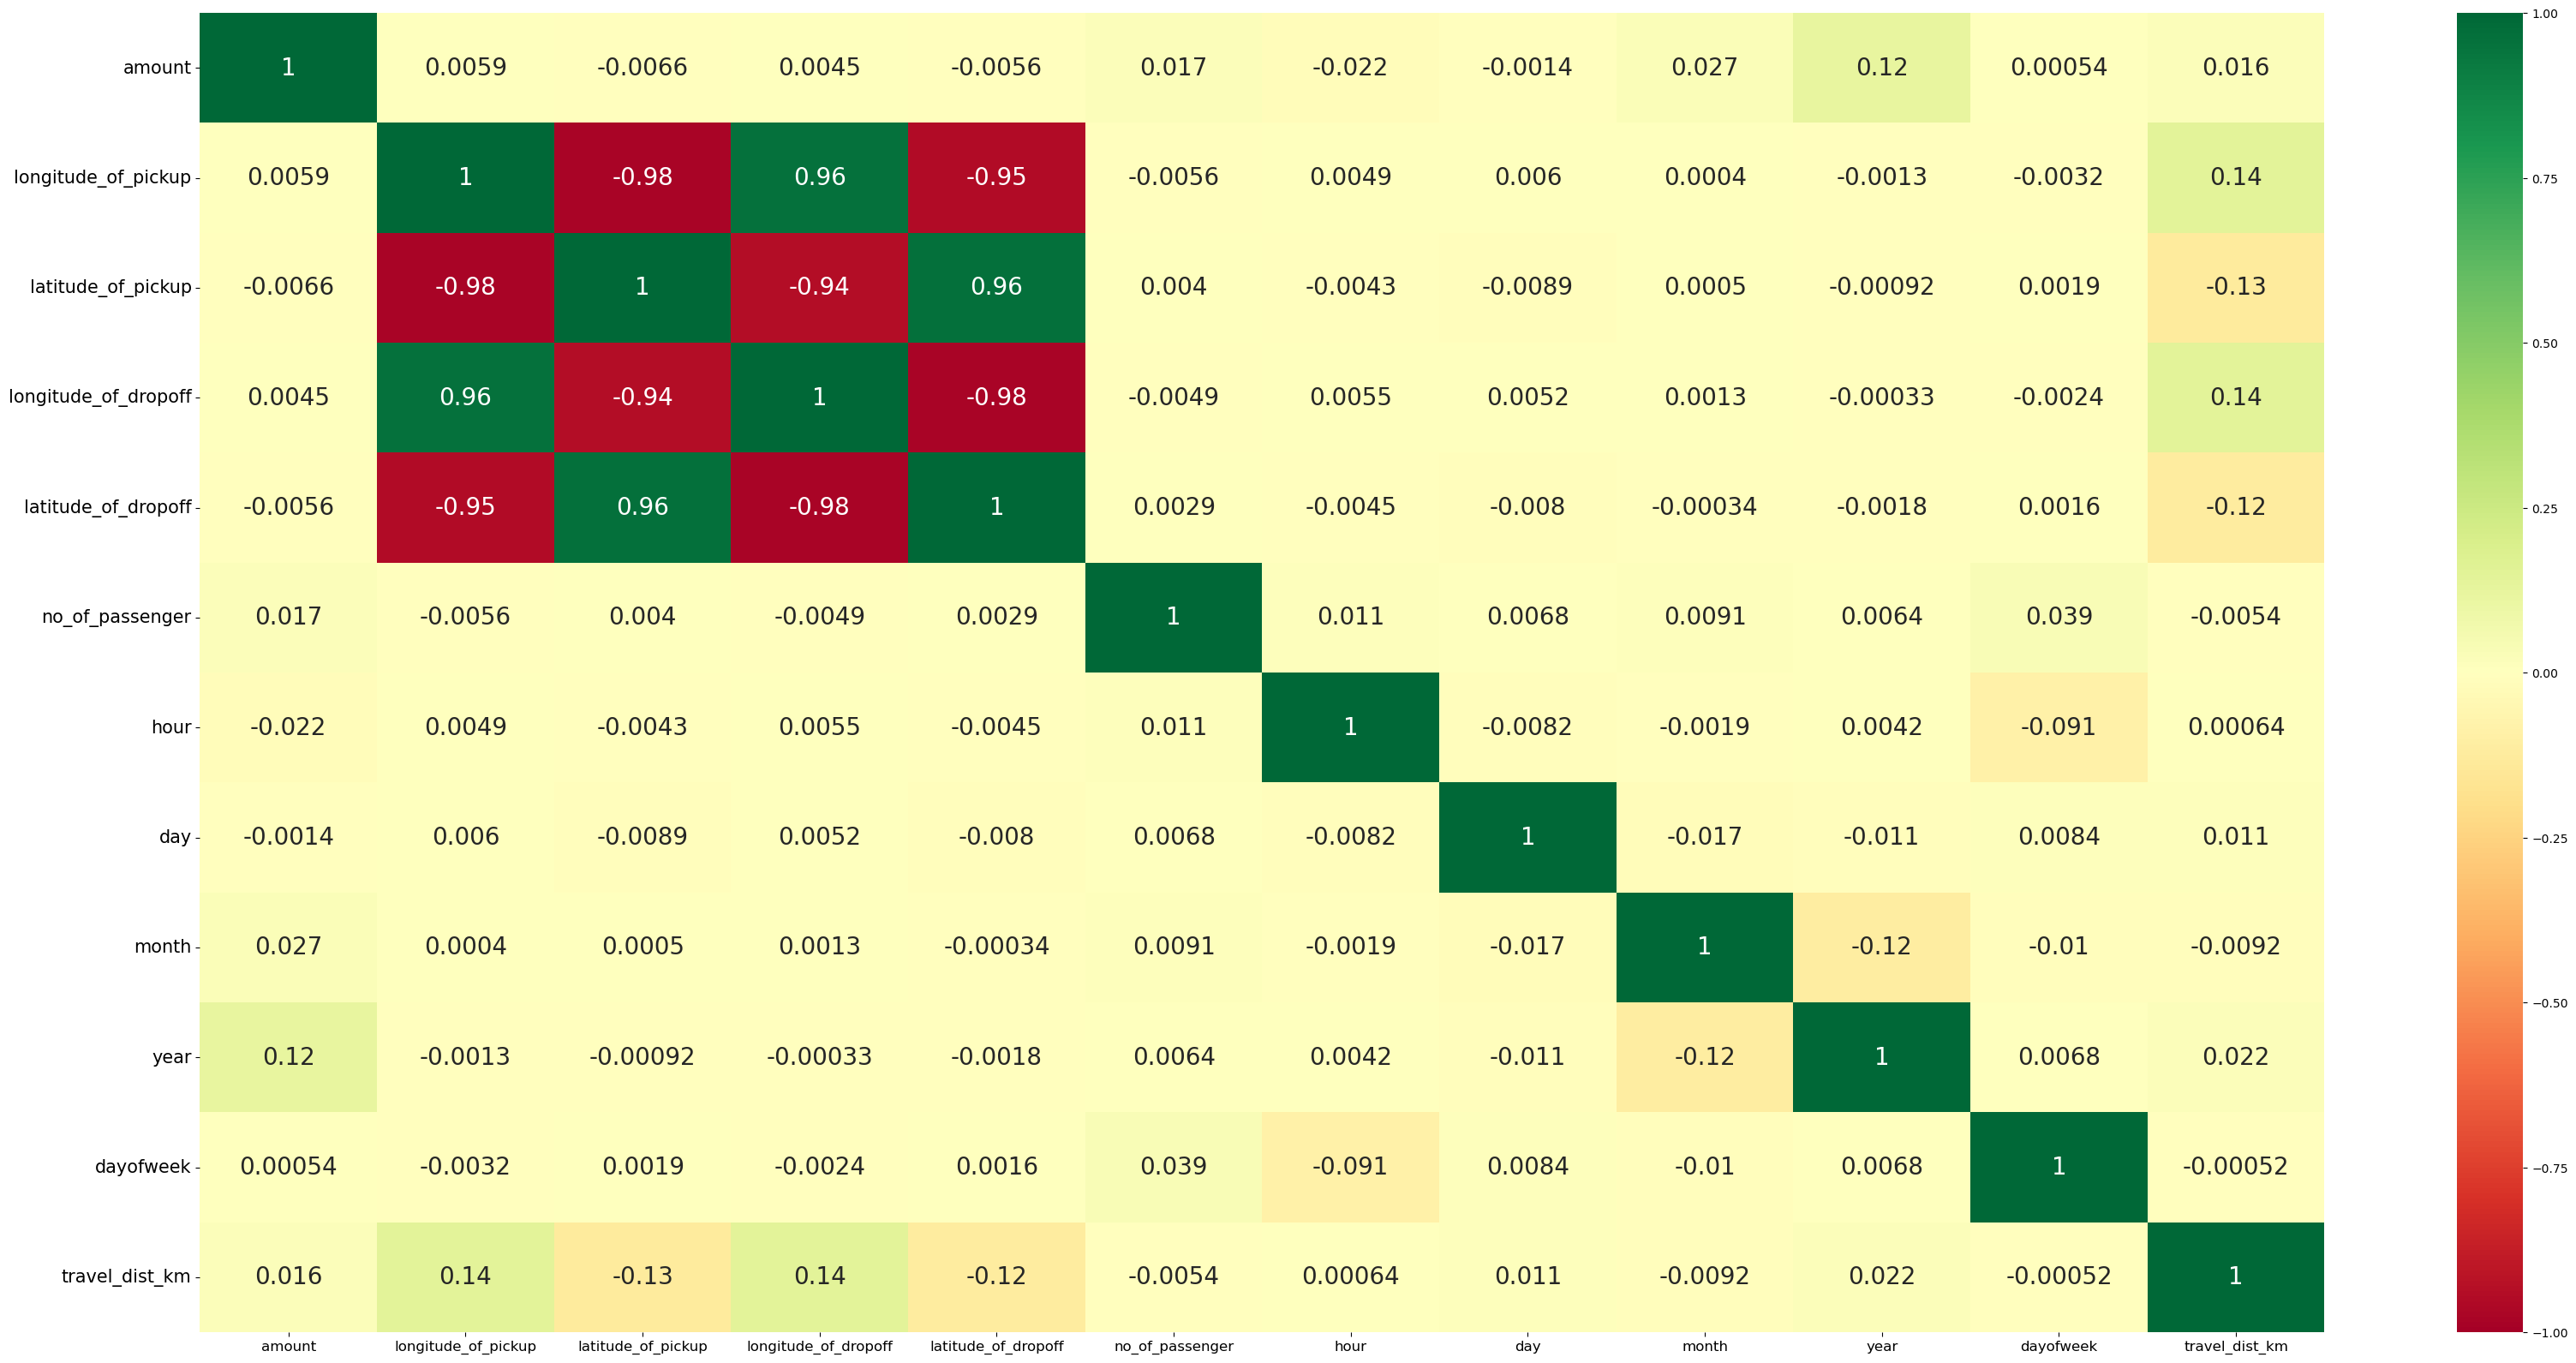

In [28]:
plt.figure(figsize = (40,20))
sns.heatmap(corr,cmap='RdYlGn', vmax = 1.0, vmin = -1.0, annot= True, annot_kws ={'size':20})
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.show()

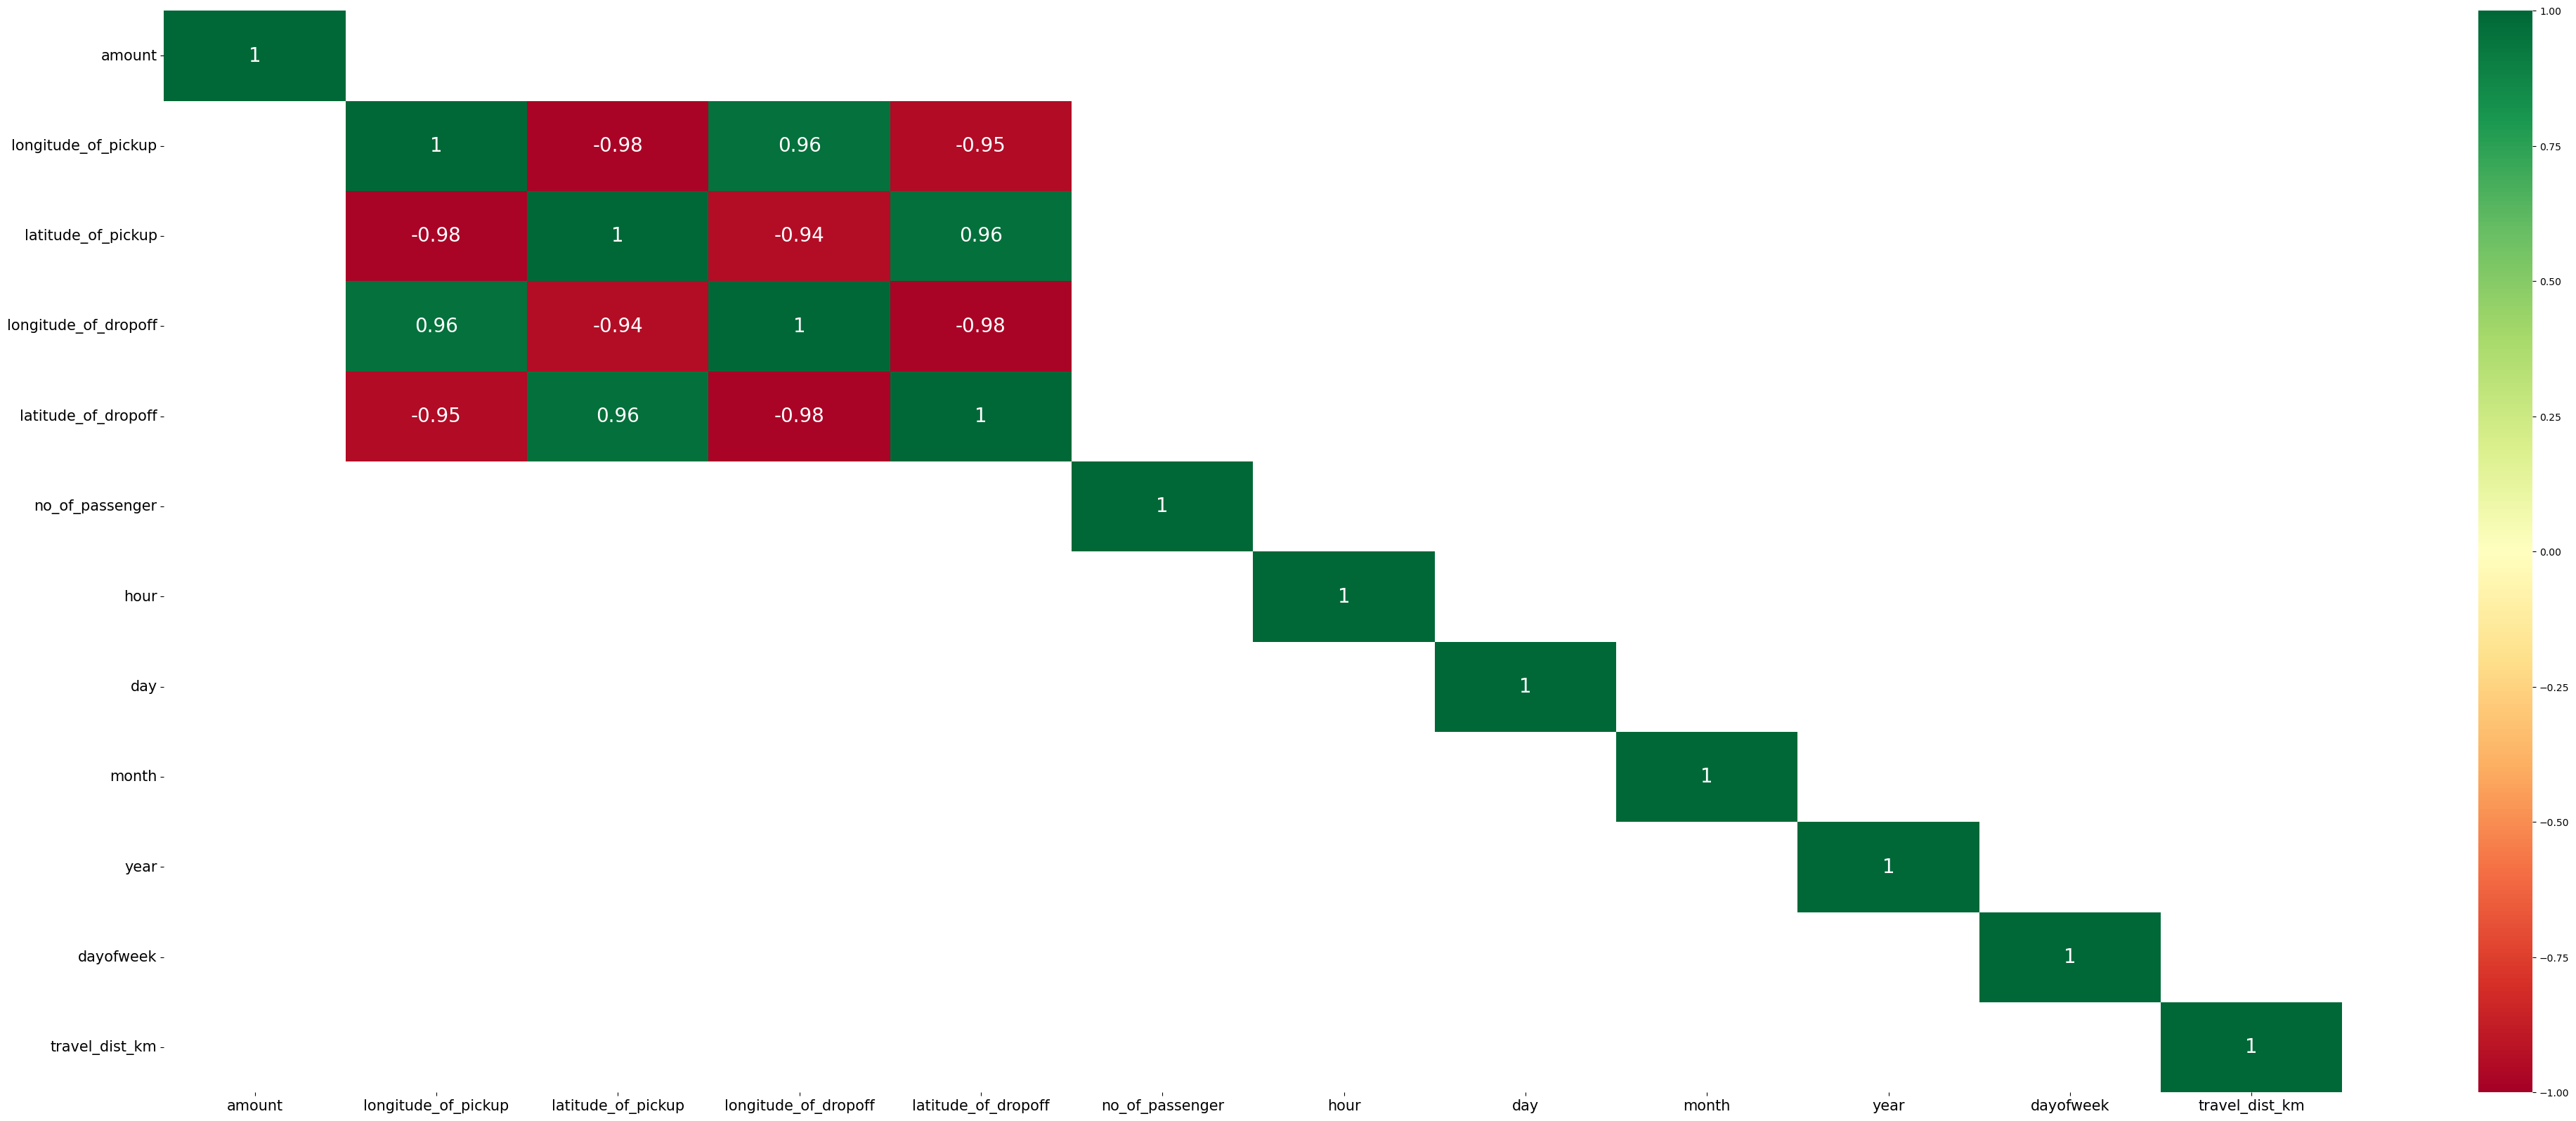

In [29]:
plt.figure(figsize=(50,20))

sns.heatmap(corr[(corr>=0.7)|(corr<=-0.7)], cmap="RdYlGn", vmax=1.0, vmin=-1.0, annot=True, annot_kws={"size":20})

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

<Axes: title={'center': 'Taxi trips count during weekdays'}, xlabel='hour', ylabel='count'>

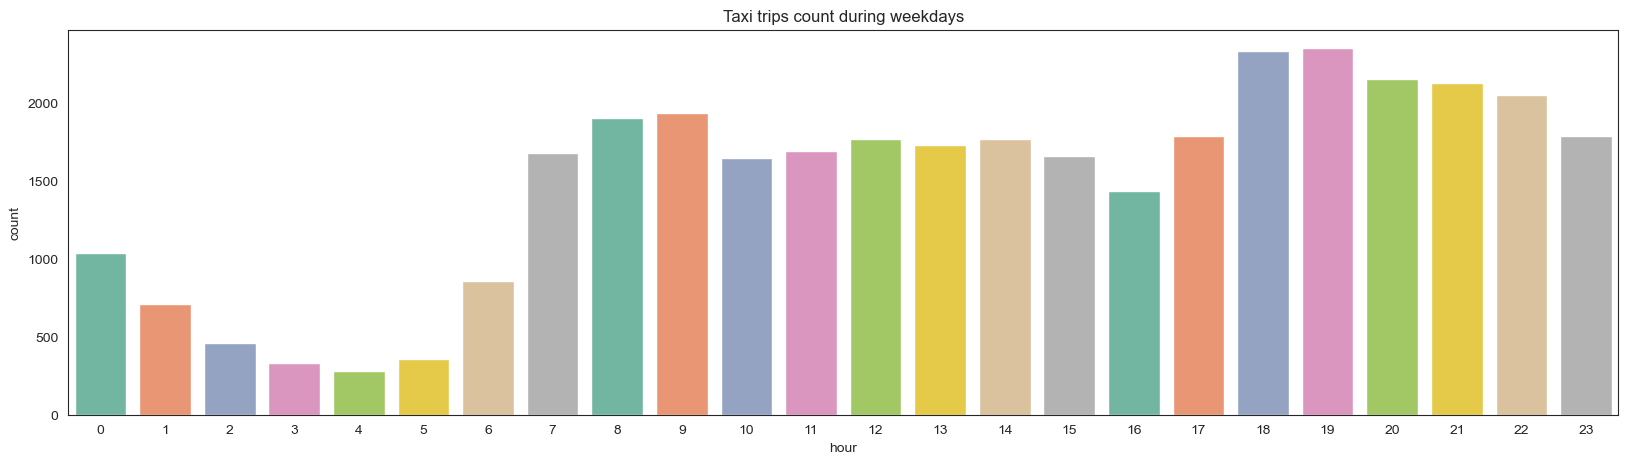

In [33]:
plt.figure(figsize=(20,5))
plt.title("Taxi trips count during weekdays")
sns.set_style("white")

sns.countplot(x="hour",data=df_taxi.loc[(df_taxi.dayofweek >= 0)&(df_taxi.dayofweek <= 4)],palette="Set2")

<Axes: title={'center': 'Taxi trips count during weekends'}, xlabel='hour', ylabel='count'>

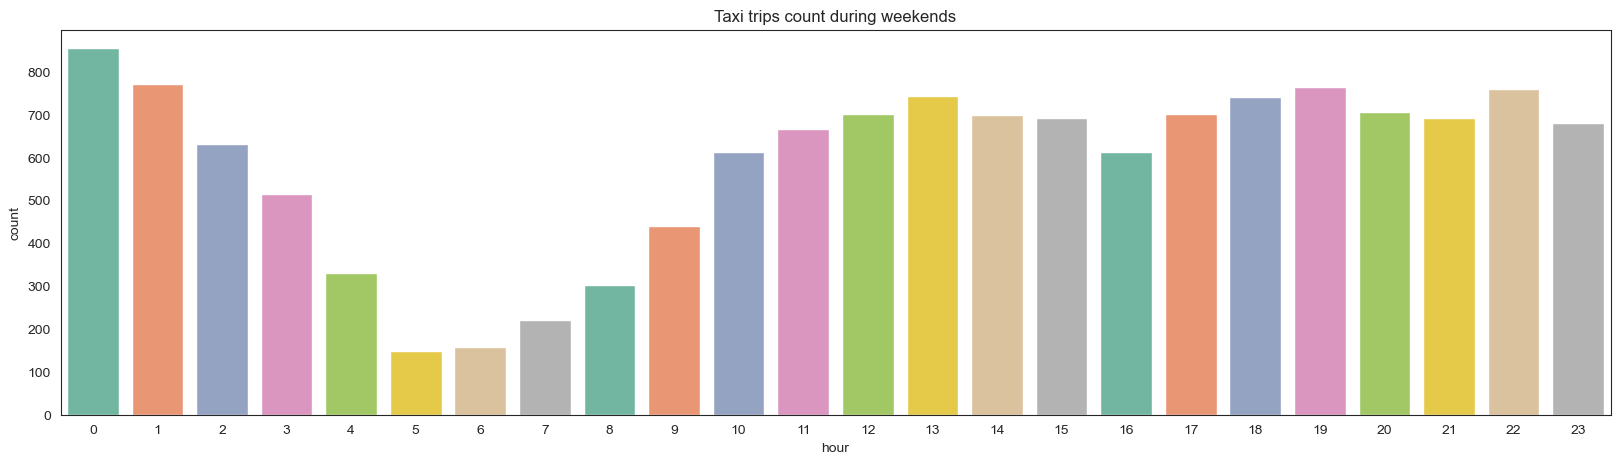

In [34]:
plt.figure(figsize=(20,5))
plt.title("Taxi trips count during weekends")
sns.set_style("white")

sns.countplot(x="hour",data=df_taxi.loc[(df_taxi.dayofweek >= 5)&(df_taxi.dayofweek <= 6)],palette="Set2")

In [35]:
week_days=df_taxi.loc[(df_taxi.dayofweek >= 0)&(df_taxi.dayofweek <= 4)]
week_ends=df_taxi.loc[(df_taxi.dayofweek >= 5)&(df_taxi.dayofweek <= 6)]

week_days_fare = week_days.groupby(["hour"]).amount.mean().to_frame().reset_index()
week_ends_fare = week_ends.groupby(["hour"]).amount.mean().to_frame().reset_index()

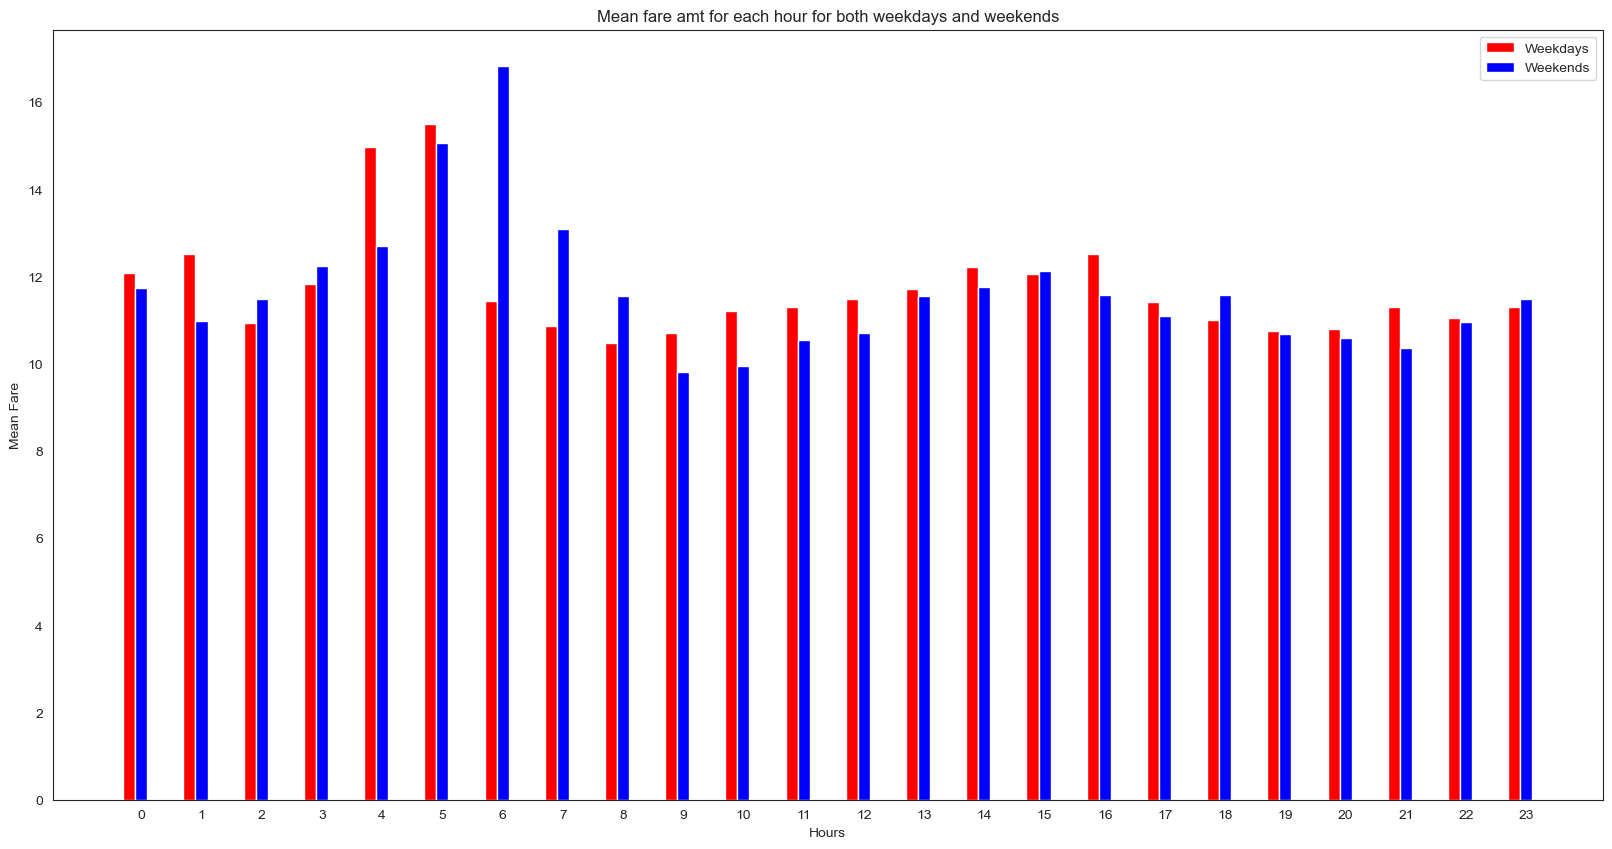

In [37]:
x = np.array(week_days_fare.hour)
y = np.array(week_days_fare.amount)
z = np.array(week_ends_fare.amount)

plt.figure(figsize=(20,10))

plt.title("Mean fare amt for each hour for both weekdays and weekends")
plt.xlabel("Hours")
plt.ylabel("Mean Fare")

ax=plt.subplot(1,1,1)
ax.bar(x-0.2,y,width=0.2,color="red",align="center",label="Weekdays")
ax.bar(x,z,width=0.2,color="blue",align="center",label="Weekends")

plt.xticks(range(0,24))
plt.legend()
plt.show()

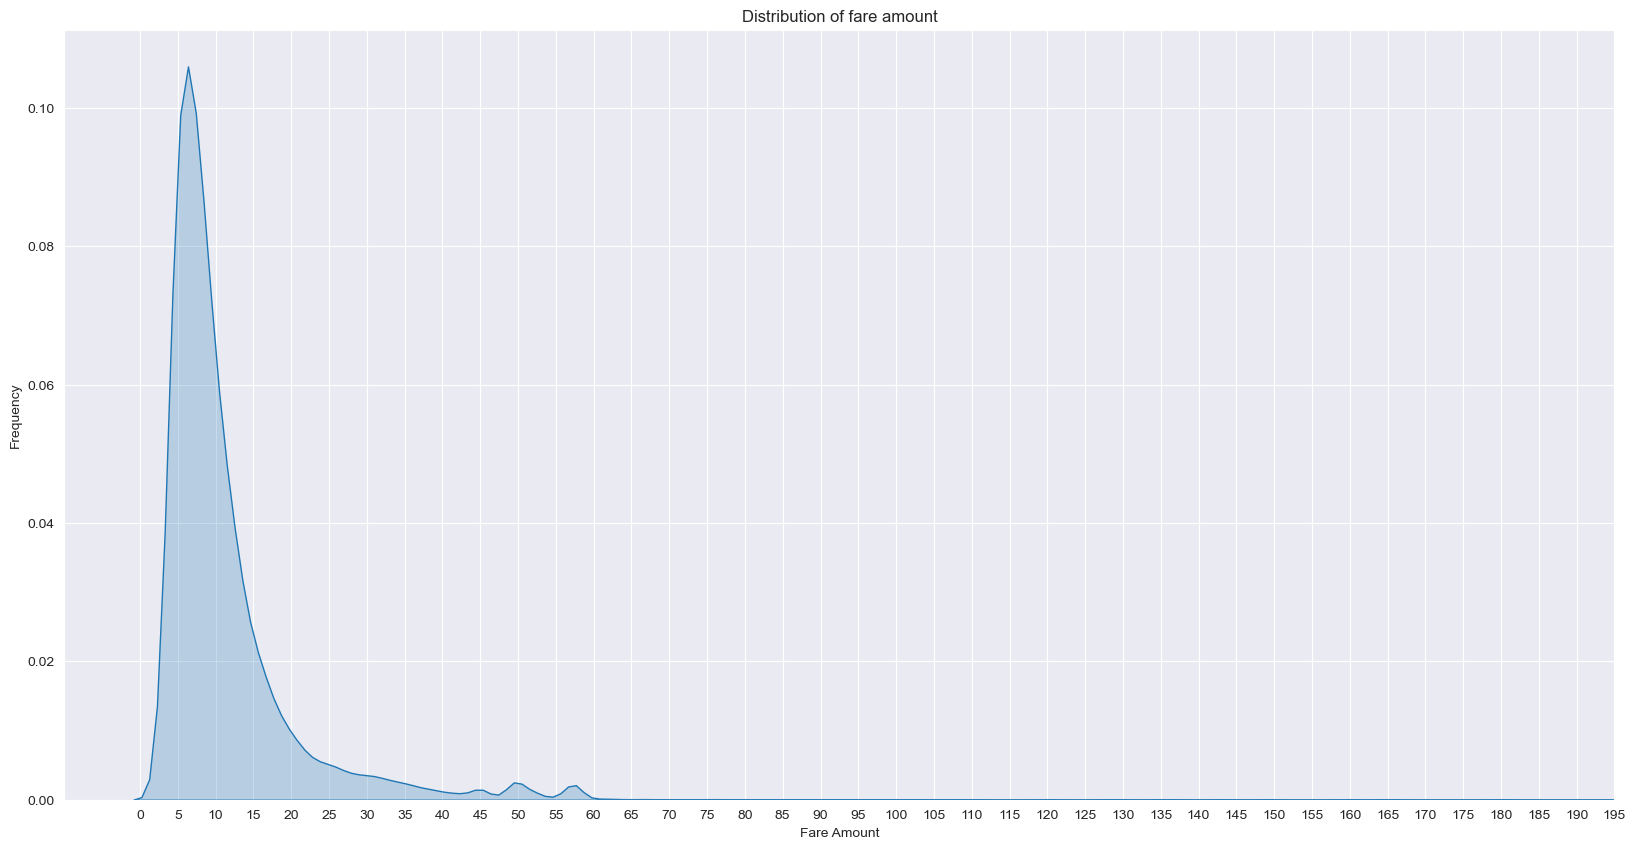

In [38]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
plt.title("Distribution of fare amount")
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.xlim(-10,20)
plt.xticks(range(0,200,5))

snsplot = sns.kdeplot(df_taxi.amount, shade=True)

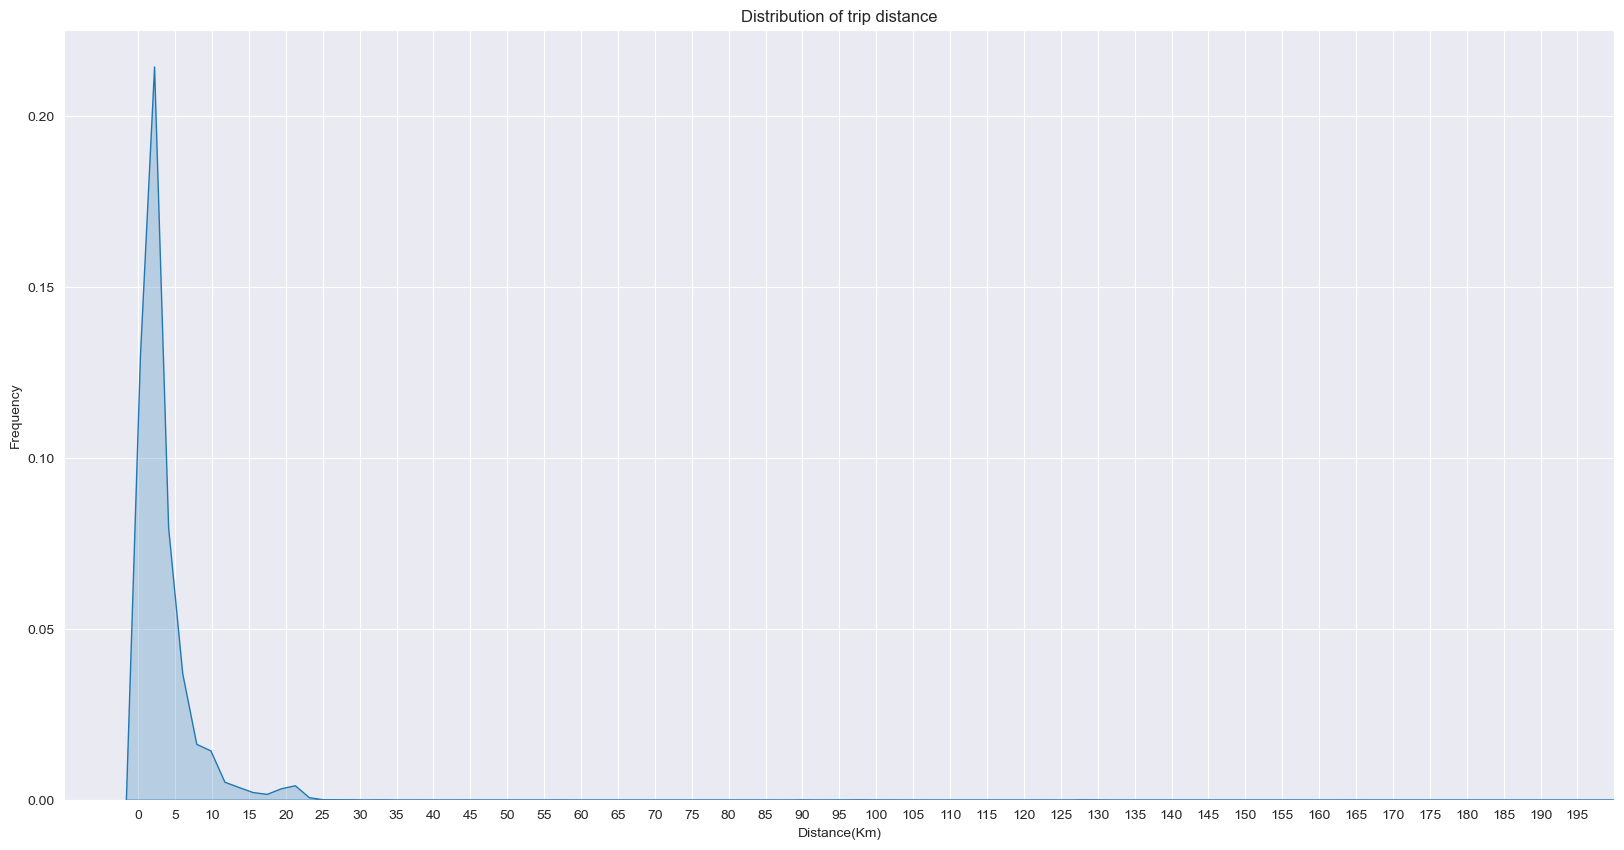

In [39]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
plt.title("Distribution of trip distance")
plt.xlabel("Distance(Km)")
plt.ylabel("Frequency")
plt.xlim(-10,200)
plt.xticks(range(0,200,5))

snsplot = sns.kdeplot(df_taxi[df_taxi.travel_dist_km < 600].travel_dist_km, shade=True)

In [40]:
y=pd.DataFrame(df_taxi["amount"])

In [43]:
X=df_taxi.drop("amount",axis=1)

In [44]:
X.head()

,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,dayofweek,travel_dist_km
0,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,2009,0,1.030764
1,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010,1,8.450134
2,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,2011,3,1.389525
3,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,2012,5,2.799270
4,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,2010,1,1.999157


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

print("X_train",X_train.shape)
print("y_train",y_train.shape)

print("X_test",X_test.shape)
print("y_test",y_test.shape)

X_train (34992, 11)
y_train (34992, 1)
X_test (14997, 11)
y_test (14997, 1)


In [46]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=10)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=10)

In [48]:
y_pred = rf_reg.predict(X_test)

In [51]:
rf_reg_MAE = metrics.mean_absolute_error(y_test,y_pred)
print("Mean Absolute Error:", rf_reg_MAE)

rf_reg_MSE = metrics.mean_squared_error(y_test,y_pred)
print("Mean Squared Error:", rf_reg_MSE)

rf_reg_RMSE = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error:", rf_reg_RMSE)

Mean Absolute Error: 2.06849660066934
Mean Squared Error: 19.606631425668667
Root Mean Squared Error: 4.427937604084848


In [52]:
cols = ["Model","MAE","MSE","RMSE"]
result_tabulation = pd.DataFrame(columns=cols)

rf_reg_metrics = pd.Series({"Model":"Random Forest ", "MAE":rf_reg_MAE, "MSE":rf_reg_MSE, "RMSE":rf_reg_RMSE})

result_tabulation = result_tabulation._append(rf_reg_metrics, ignore_index = True)

result_tabulation

,Model,MAE,MSE,RMSE
0,Random Forest,2.068497,19.606631,4.427938


In [53]:
tuned_parameters = [{"n_estimators":[85,100],
                     "min_samples_split":[15,20],
                     "max_depth":[8,10],
                     "min_samples_leaf":[5,10],
                     "max_leaf_nodes":[10,15]}]

In [54]:
rf_reg_CV = RandomForestRegressor(random_state=10)

grid = GridSearchCV(estimator = rf_reg_CV, param_grid = tuned_parameters, cv=10)

dt_grid = grid.fit(X_train,y_train)

print("Best parameters for Random Forest Regressor: ", dt_grid.best_params_, "\n")

Best parameters for Random Forest Regressor:  {'max_depth': 8, 'max_leaf_nodes': 15, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 100} 



In [57]:
dt_grid_model = RandomForestRegressor(n_estimators = dt_grid.best_params_.get('n_estimators'),
                                       max_depth = dt_grid.best_params_.get('max_depth'),
                                       max_leaf_nodes = dt_grid.best_params_.get('max_leaf_nodes'),
                                       min_samples_leaf = dt_grid.best_params_.get('min_samples_leaf'),
                                       min_samples_split = dt_grid.best_params_.get('min_samples_split'),
                                       random_state = 10)


dt_grid_model = dt_grid_model.fit(X_train, y_train)

In [58]:
y_pred = dt_grid_model.predict(X_test)

In [59]:
# calculate MAE
rf_reg_CV_MAE = metrics.mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', rf_reg_CV_MAE)
                                         
# calculate MSE
rf_reg_CV_MSE = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error (MSE):', rf_reg_CV_MSE)
                                         
# calculate RMSE
rf_reg_CV_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rf_reg_CV_RMSE)

Mean Absolute Error (MAE): 2.4707931553402824
Mean Squared Error (MSE): 22.41363262082127
Root Mean Squared Error (RMSE): 4.734303815855218


In [61]:
# compile the required information
rf_reg_metrics = pd.Series({'Model': "Random Forest with GridSearchCV ",
                     'MAE':rf_reg_CV_MAE,
                     'MSE': rf_reg_CV_MSE,
                     'RMSE': rf_reg_CV_RMSE     
                   })

# append our result table using append()
# ignore_index=True: does not use the index labels
# python can only append a Series if ignore_index=True or if the Series has a name
result_tabulation = result_tabulation._append(rf_reg_metrics, ignore_index = True)

# print the result table
result_tabulation

,Model,MAE,MSE,RMSE
0,Random Forest,2.068497,19.606631,4.427938
1,Random Forest with GridSearchCV,2.470793,22.413633,4.734304
